# Лабораторная работа № 4 по дисциплине "Системы искусственного интеллекта"

## Задание лабораторной работы
0. Датасет:
    - [Датасет про диабет](https://www.kaggle.com/datasets/abdallamahgoub/diabetes/data)
1. Проведите предварительную обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и масштабирование.
2. Получите и визуализируйте (графически) статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили), постройте 3d-визуализацию признаков.
3. Реализуйте метод k-ближайших соседей без использования сторонних библиотек, кроме NumPy и Pandas.
4. Постройте две модели k-NN с различными наборами признаков:
    - Модель 1: Признаки случайно отбираются.
    - Модель 2: Фиксированный набор признаков, который выбирается заранее.
5. Для каждой модели проведите оценку на тестовом наборе данных при разных значениях k. Выберите несколько различных значений k, например, k=3, k=5, k=10, и т. д. Постройте матрицу ошибок.

## Выполнение лабораторной работы
### 0. Установка и импорт библиотек, загрузка датасета

Сначала установим библиотеки, если они уже не установлены.

In [1]:
import math
!pip install numpy pandas matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые библиотеки.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим датасет и выведем основную статистику по нему и 5 первых строк:

In [3]:
data = pd.read_csv('diabetes.csv')
print(data.describe())
data.head()

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI    Pedigree         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885    0.348958  
std      7.884160    0.331329   11.760232    0.476951  
min      0.000000    0.078000   21.000000    0.000000  
25%     27.300000    0.243750   24.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1. Обработка значений

#### 1.1. Фильтрация отсутствующих значений

Проверим наличие рядов с отсутствующими значениями. Удалим строки с пропущенными значениями:

In [4]:
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)
rows_to_delete = data.isnull().any(axis='columns').sum()
data = data.dropna(axis='rows')
print("Deleted rows:", rows_to_delete)

Missing values per column:
Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
Pedigree         0
Age              0
Outcome          0
dtype: int64
Deleted rows: 0


Можно заметить, что в некоторых столбцах значительное количество значений `0` там, где они недопустимы (столбцы `Glucose`, `BloodPressure`, `SkinThickness`, `BMI`). Предположительно, эти нули были вставлены вместо отсутствующих значений. Удалим строки с нулевыми значениями этих столбцов:

In [5]:
labels_to_filter = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
zeroes_per_column = (data[labels_to_filter] == 0).sum()
print('Zero values per column:')
print(zeroes_per_column)

rows_to_delete = (data[labels_to_filter] == 0).any(axis='columns').sum()
print(f'Row count to delete: {rows_to_delete}')

data = data[(data[labels_to_filter] != 0).all(axis=1)]
data.describe()


Zero values per column:
Glucose            5
BloodPressure     35
SkinThickness    227
BMI               11
dtype: int64
Row count to delete: 236


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,29.182331,114.988722,32.890226,0.502966,31.614662,0.332707
std,3.312036,30.999226,12.310253,10.523878,123.007555,6.881109,0.344546,10.761584,0.471626
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,22.000000,0.000000,27.875000,0.258750,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,91.500000,32.800000,0.416000,28.000000,0.000000
75%,5.000000,141.250000,80.000000,36.000000,165.250000,36.900000,0.658500,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 1.2. Кодирование категориальных признаков

Проверим, есть ли категориальные признаки, которые нужно кодировать.

In [6]:
list(data.select_dtypes(include=['object', 'string', 'boolean']).columns)

[]

Таких признаков нет; все числовые. Поэтому категориальные признаки не нужно кодировать.

#### 1.3. Нормализация данных

Нормализуем данные.

Нормализацию осуществляем по принципу:
$$
x_i' = \cfrac{x_i - \bar{X}}{\sigma},
$$
где $\bar X$ -- выборочное среднее, $\sigma$ -- стандартное отклонение.

In [7]:
norm_data = (data - data.mean()) / data.std()
norm_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,0.749715,0.870019,0.040158,0.552807,-0.934810,0.103148,0.359992,1.708423,1.414878
1,-0.759931,-1.162290,-0.447240,-0.017325,-0.934810,-0.914130,-0.441062,-0.057116,-0.705446
3,-0.759931,-1.033254,-0.447240,-0.587457,-0.170630,-0.696142,-0.975097,-0.986348,-0.705446
4,-1.061860,0.515172,-2.559301,0.552807,0.430960,1.483740,5.180825,0.128730,1.414878
6,-0.156072,-1.388102,-1.746970,0.267741,-0.219407,-0.274698,-0.740006,-0.521732,1.414878


### 2. Визуализация статистики

#### 2.1. Диаграммы для каждого из признаков

Статистика по каждому из полей датасета:

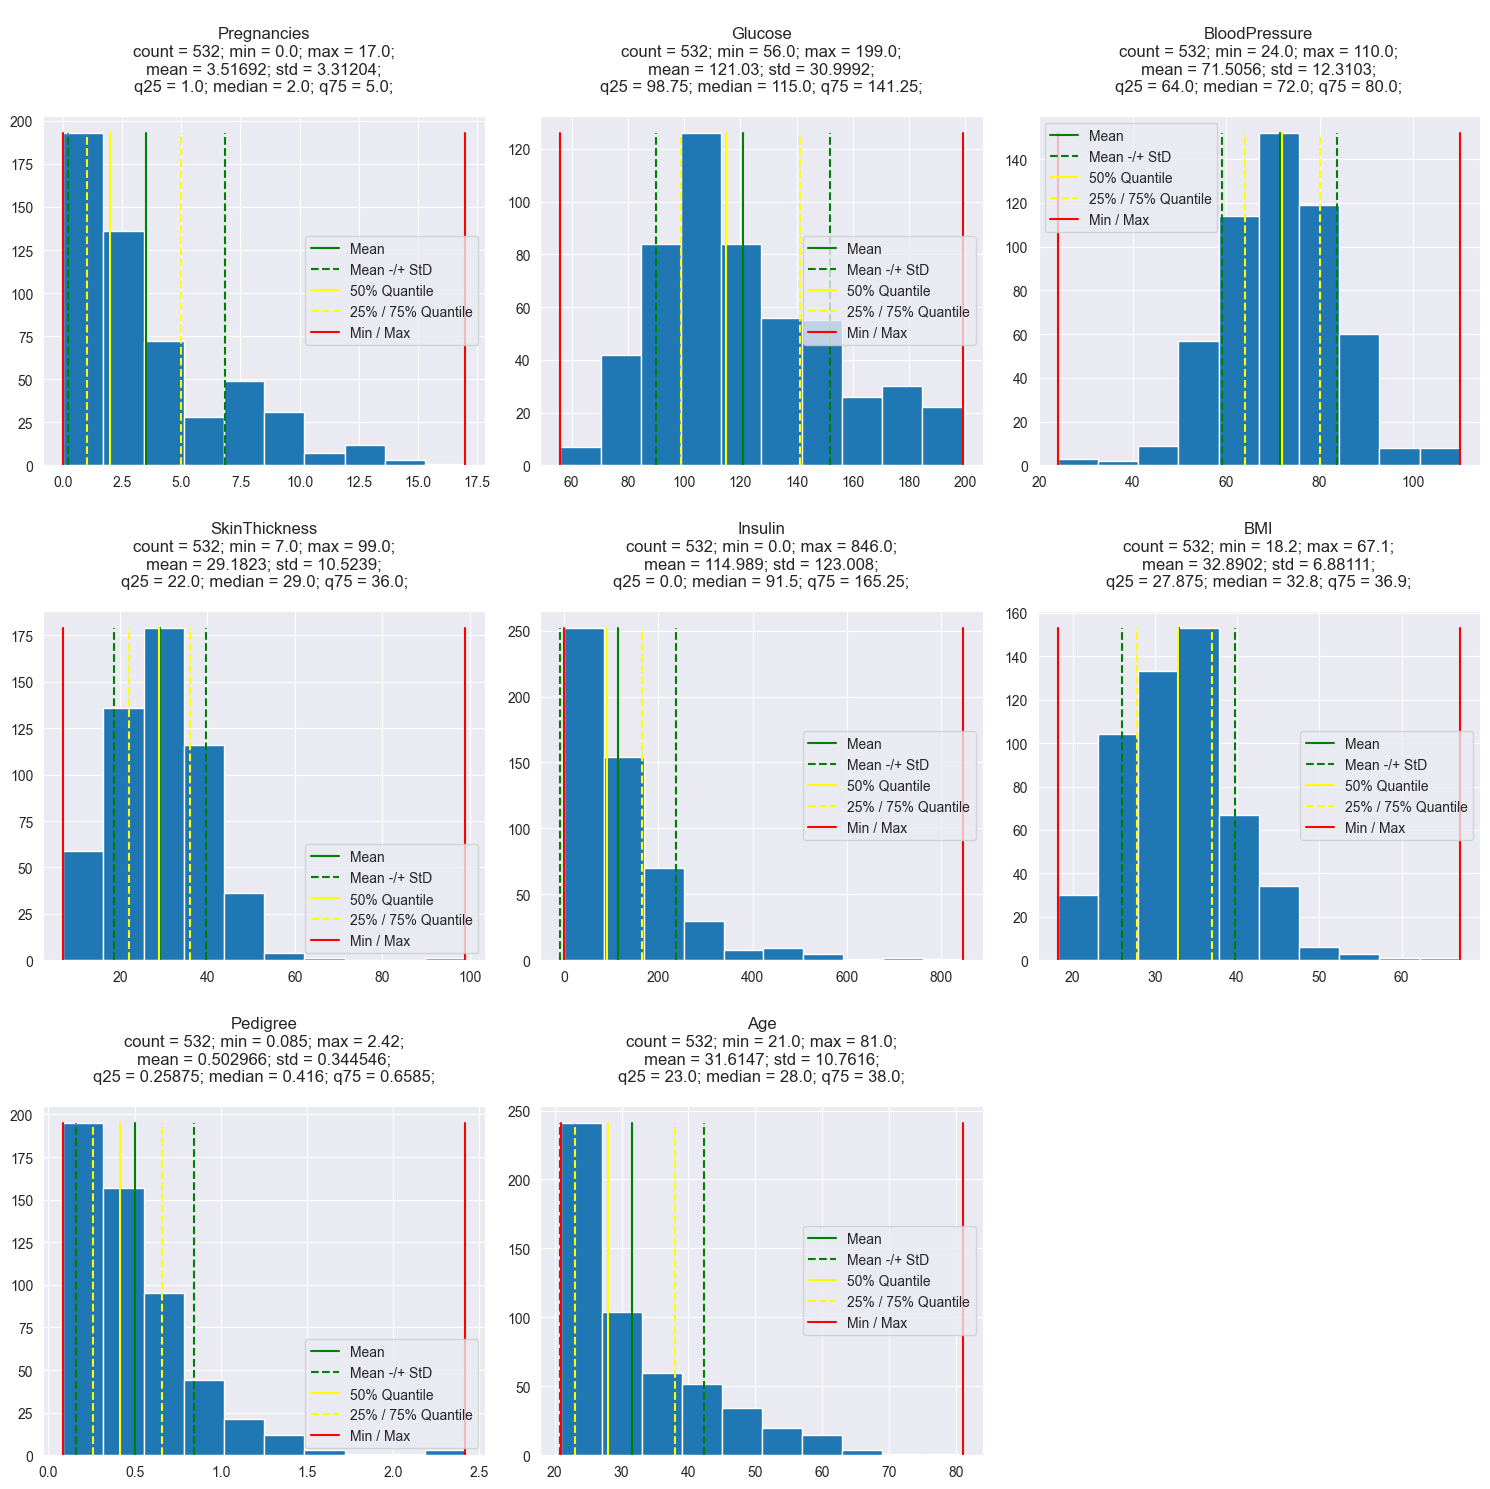

In [8]:
# Правило Стёрджиса для выбора оптимального количества интервалов в гистограмме 
def sturges(n):
    return int(1 + np.floor(np.log2(n)))

desc = data.describe()

num_rows = (len(desc.columns) + 2) // 3

fig = plt.figure(figsize=(15, num_rows * 5))

non_numeric_column_count = 0

for i, col in enumerate(desc.columns):
    if col == 'Outcome':
        non_numeric_column_count += 1
        continue

    ax = fig.add_subplot(num_rows, 3, i + 1 - non_numeric_column_count)

    bin_count = min(sturges(len(data[col])), len(data[col].unique()))

    hist = ax.hist(data[col], bins=bin_count)

    count = int(desc[col]['count'])
    mean = desc[col]['mean']
    std = desc[col]['std']
    min_val = desc[col]['min']
    max_val = desc[col]['max']
    q25 = desc[col]['25%']
    median = desc[col]['50%']
    q75 = desc[col]['75%']

    line_mean = ax.plot([mean, mean], [0, np.max(hist[0])], color='green', label='Mean')
    line_mean_minus_std = ax.plot([mean - std, mean - std], [0, np.max(hist[0])],
                                  color='green', linestyle='dashed', label='Mean -/+ StD ')
    line_mean_plus_std = ax.plot([mean + std, mean + std], [0, np.max(hist[0])],
                                 color='green', linestyle='dashed')
    line_median = ax.plot([median, median], [0, np.max(hist[0])],
                          color='yellow', label='50% Quantile')
    line_q25 = ax.plot([q25, q25], [0, np.max(hist[0])],
                       color='yellow', linestyle='dashed', label='25% / 75% Quantile')
    line_q75 = ax.plot([q75, q75], [0, np.max(hist[0])],
                       color='yellow', linestyle='dashed')
    line_min = ax.plot([min_val, min_val], [0, np.max(hist[0])], color='red', label='Min / Max')
    line_max = ax.plot([max_val, max_val], [0, np.max(hist[0])], color='red')

    ax.set_title(
        f"""
{col}
count = {count}; min = {min_val:.6}; max = {max_val:.6};
mean = {mean:.6}; std = {std:.6};
q25 = {q25:.6}; median = {median:.6}; q75 = {q75:.6};
"""
    )
    ax.legend()
    ax.plot()


fig.tight_layout()
plt.show()

#### 2.2. Корреляция признаков

Построим корреляционную матрицу признаков:

In [9]:
correlation_matrix = data.corr()
correlation_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
Pregnancies,1.000000,0.125330,0.204663,0.095085,-0.006568,0.008576,0.007435,0.640747,0.252586
Glucose,0.125330,1.000000,0.219178,0.226590,0.459905,0.247079,0.165817,0.278907,0.503614
BloodPressure,0.204663,0.219178,1.000000,0.226072,0.007052,0.307357,0.008047,0.346939,0.183432
SkinThickness,0.095085,0.226590,0.226072,1.000000,0.126240,0.647422,0.118636,0.161336,0.254874
Insulin,-0.006568,0.459905,0.007052,0.126240,1.000000,0.191168,0.151531,0.081126,0.212204
BMI,0.008576,0.247079,0.307357,0.647422,0.191168,1.000000,0.151107,0.073438,0.300901
Pedigree,0.007435,0.165817,0.008047,0.118636,0.151531,0.151107,1.000000,0.071654,0.233074
Age,0.640747,0.278907,0.346939,0.161336,0.081126,0.073438,0.071654,1.000000,0.315097
Outcome,0.252586,0.503614,0.183432,0.254874,0.212204,0.300901,0.233074,0.315097,1.000000


и тепловую карту на её основе:

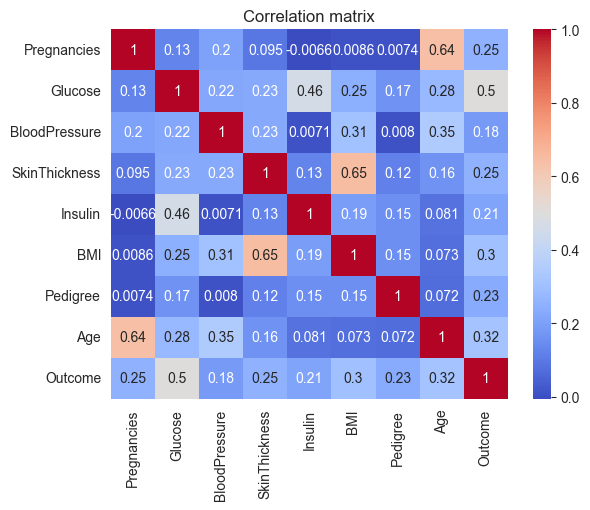

In [10]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

#### 2.3. 3D-визуализация признаков

Выбираем 3 случайных признака:

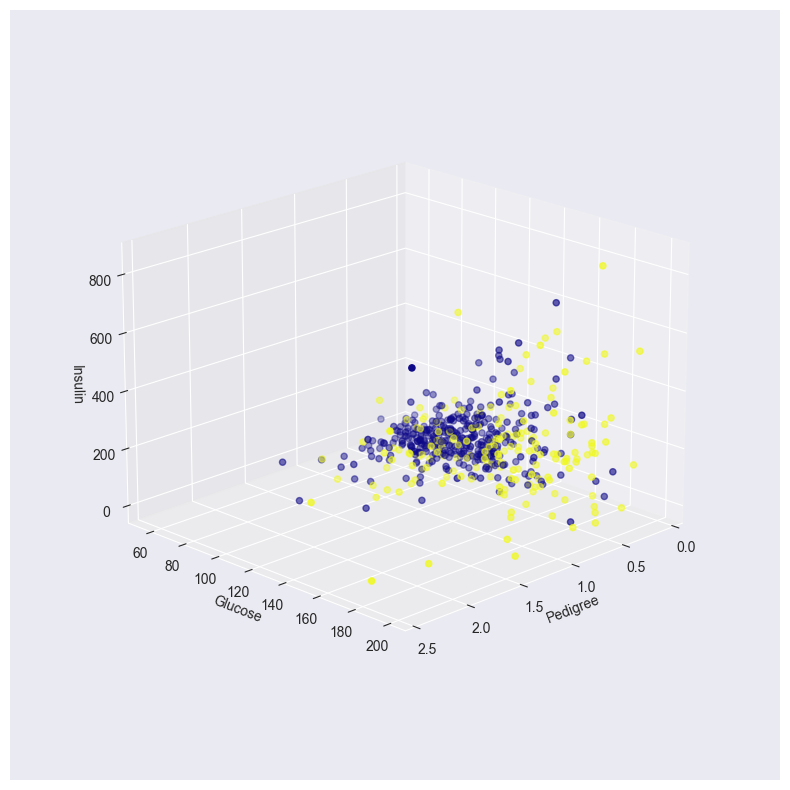

In [11]:
x = data.drop('Outcome', axis='columns')
y = data['Outcome']

random_columns = x.sample(3, axis='columns')

coord_x = random_columns.iloc[:, 0]
coord_y = random_columns.iloc[:, 1]
coord_z = random_columns.iloc[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coord_x, coord_y, coord_z, c=y, cmap='plasma')
ax.set_xlabel(random_columns.columns[0])
ax.set_ylabel(random_columns.columns[1])
ax.set_zlabel(random_columns.columns[2])
ax.view_init(elev=19.45, azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.8)

fig.tight_layout()
plt.show()

Выбираем 3 фиксированных признака:

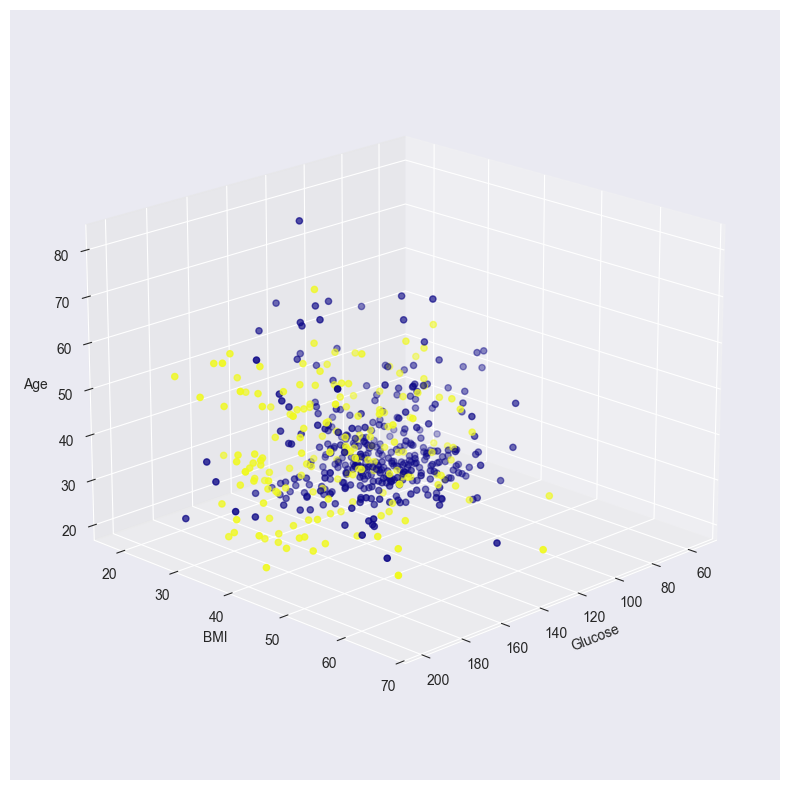

In [12]:
columns = x[['Glucose', 'BMI', 'Age']]

coord_x = columns.iloc[:, 0]
coord_y = columns.iloc[:, 1]
coord_z = columns.iloc[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coord_x, coord_y, coord_z, c=y, cmap='plasma')
ax.set_xlabel(columns.columns[0])
ax.set_ylabel(columns.columns[1])
ax.set_zlabel(columns.columns[2])
ax.view_init(elev=19.45, azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.9)

fig.tight_layout()
plt.show()

### 3. Реализация метода $k$-ближайших соседей (k-NN)

In [13]:
def distance(left: np.ndarray, right: np.ndarray, kind: str = 'euclidean') -> np.float64:
    """
    Calculate the distance between two individual points based on the selected distance metric.

    :param left: First point (n_features,)
    :param right: Second point (n_features,)
    :param kind: Type of distance metric ('euclidean', 'manhattan', 'chebyshev')
    :return: The computed distance
    """
    if (not isinstance(left, np.ndarray) or not isinstance(right, np.ndarray)):
        print(left, right)

    if kind == 'euclidean':
        return np.linalg.norm(left - right)
    elif kind == 'manhattan':
        return np.sum(np.abs(left - right))
    elif kind == 'chebyshev':
        return np.max(np.abs(left - right))
    else:
        raise ValueError('Unsupported distance kind')


class KNNClassifier:
    def __init__(self, k: int = 3) -> None:
        """
        Initialize the kNN classifier.
        
        :param k: Number of neighbors to consider for voting.
        """
        self.k = k
        self.x_train: np.ndarray = np.array([])
        self.y_train: np.ndarray = np.array([])

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the classifier on the training data.
        
        :param x: Training data (features), of shape (n_samples, n_features)
        :param y: Training labels, of shape (n_samples,)
        """
        self.x_train = x
        self.y_train = y

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predict the labels for the input data using the kNN algorithm.
        
        :param x: Test data (features), of shape (n_samples, n_features)
        :return: Predicted labels, of shape (n_samples,)
        """
        predictions = [self._predict_single(x_val) for x_val in x]
        return np.array(predictions)

    def _predict_single(self, x_val: np.ndarray) -> int:
        """
        Predict the label for a single test sample.
        
        :param x_val: A single test sample of shape (n_features,)
        :return: Predicted label for the test sample.
        """
        # Compute distances from the test point x_val to all training points
        distances = np.array([distance(train_point, x_val, 'euclidean') for train_point in self.x_train])

        # Get the indices of the k nearest neighbors
        k_nearest_indices = np.argsort(distances)[:self.k]
        
        # Extract the labels of the k nearest neighbors
        k_nearest_labels = self.y_train[k_nearest_indices]
        
        # Perform majority voting (the most common label)
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
        return unique_labels[np.argmax(counts)]

Добавим функции для оценки точности моделей -- матрицу ошибок, precision, recall, метрику F1:

In [14]:
def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i, true_label in enumerate(classes):
        for j, pred_label in enumerate(classes):
            matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
    return matrix

def precision(cm: np.ndarray) -> np.float64:
    assert cm.shape == (2, 2)
    [tp, _, fp, _] = cm.ravel()
    denominator = tp + fp
    if denominator == 0:
        return np.nan # or np.nan, depending on preference
    return tp / denominator

def recall(cm: np.ndarray) -> np.float64:
    assert cm.shape == (2, 2)
    [tp, fn, _, _] = cm.ravel()
    denominator = tp + fn
    if denominator == 0:
        return np.nan
    return tp / denominator

def f1(cm: np.ndarray) -> np.float64:
    p = precision(cm)
    r = recall(cm)
    denominator = p + r
    if denominator == 0:
        return np.nan
    return 2 * p * r / denominator

### 4. Построение моделей
#### 4.0. Разделение на тестовую и обучающую выборки

In [15]:
TRAIN_DATA_PERCENTAGE = 0.8
assert 0 < TRAIN_DATA_PERCENTAGE < 1

In [16]:
norm_data = norm_data.sample(frac=1, random_state=267)

x = norm_data.drop('Outcome', axis='columns')
y = norm_data['Outcome']

train_size = int(TRAIN_DATA_PERCENTAGE * x.shape[0])
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

# Could have used sklearn.model_selection.train_test_split, but not sure if the task allows it

Создадим класс для хранения результатов работы моделей:

In [17]:
from dataclasses import dataclass

@dataclass
class KNNResult:
    columns: list[str]
    k: int
    cm: np.ndarray
    metrics: dict[str, np.float64]

    def __repr__(self):
        def confusion_matrix_to_str(cm):
            [tp, fn, fp, tn] = np.ravel(cm)
            return f'TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}'
        
        _tabs = '\n\t\t'
        return f'''knn_result(
    k = {self.k},
    columns = {self.columns}
    confusion_matrix = {{{confusion_matrix_to_str(self.cm)}}}
    metrics = (
        {_tabs.join(f"{key}: {value:.4f}" for key, value in self.metrics.items())}
    )
)'''


In [18]:
results: list[KNNResult] = []

In [19]:
def run_model(
        k: int, 
        x_train_values: np.ndarray,
        x_test_values: np.ndarray,
        y_train_values: np.ndarray,
        y_test_values: np.ndarray,
        column_names: list[str]
) -> KNNResult:
    knn_random = KNNClassifier(k=k)
    knn_random.fit(x_train_values, y_train_values)
    
    y_pred_random = knn_random.predict(x_test_values)  # Extract data as NumPy array
    
    cm = confusion_matrix(y_true=y_test_values, y_pred=y_pred_random)
    
    result = KNNResult(
        columns = column_names,
        k = k,
        cm = cm,
        metrics = {
            'precision': precision(cm),
            'recall': recall(cm),
            'f1_score': f1(cm),
        }
    )
    return result

#### 4.1. Модель на основе случайных признаков

In [20]:
random_column_names = x.sample(3, axis='columns', random_state=267).columns
x_train_random = x_train[random_column_names]
x_test_random = x_test[random_column_names]

print(f'Selected features: {list(random_column_names)}')

for k in [3, 5, 10, 30, 50, 100]:
    print(f'k = {k}')
    result = run_model(
        k = k,
        x_train_values = x_train_random.values,
        x_test_values = x_test_random.values,
        y_train_values = y_train.values,
        y_test_values = y_test.values,
        column_names = list(random_column_names) 
    )
    results.append(result)
    print(result)
    

Selected features: ['BMI', 'Pregnancies', 'BloodPressure']
k = 3
knn_result(
    k = 3,
    columns = ['BMI', 'Pregnancies', 'BloodPressure']
    confusion_matrix = {TP: 56, FN: 13, FP: 25, TN: 13}
    metrics = (
        precision: 0.6914
		recall: 0.8116
		f1_score: 0.7467
    )
)
k = 5
knn_result(
    k = 5,
    columns = ['BMI', 'Pregnancies', 'BloodPressure']
    confusion_matrix = {TP: 55, FN: 14, FP: 28, TN: 10}
    metrics = (
        precision: 0.6627
		recall: 0.7971
		f1_score: 0.7237
    )
)
k = 10
knn_result(
    k = 10,
    columns = ['BMI', 'Pregnancies', 'BloodPressure']
    confusion_matrix = {TP: 66, FN: 3, FP: 30, TN: 8}
    metrics = (
        precision: 0.6875
		recall: 0.9565
		f1_score: 0.8000
    )
)
k = 30
knn_result(
    k = 30,
    columns = ['BMI', 'Pregnancies', 'BloodPressure']
    confusion_matrix = {TP: 67, FN: 2, FP: 32, TN: 6}
    metrics = (
        precision: 0.6768
		recall: 0.9710
		f1_score: 0.7976
    )
)
k = 50
knn_result(
    k = 50,
    column

#### 4.2. Модель на основе фиксированных признаков

Выберем признаки `['Glucose', 'BMI', 'Age']`, т. к. у них наибольший коэффициент корреляции с `Outcome`.

In [21]:
fixed_column_names = ['Glucose', 'BMI', 'Age']
x_train_fixed = x_train[fixed_column_names]
x_test_fixed = x_test[fixed_column_names]

print(f'Selected features: {list(fixed_column_names)}')

for k in [3, 5, 10, 30, 50, 100]:
    print(f'k = {k}')
    result = run_model(
        k = k,
        x_train_values = x_train_fixed.values,
        x_test_values = x_test_fixed.values,
        y_train_values = y_train.values,
        y_test_values = y_test.values,
        column_names = fixed_column_names
    )
    results.append(result)
    print(result)

Selected features: ['Glucose', 'BMI', 'Age']
k = 3
knn_result(
    k = 3,
    columns = ['Glucose', 'BMI', 'Age']
    confusion_matrix = {TP: 59, FN: 10, FP: 22, TN: 16}
    metrics = (
        precision: 0.7284
		recall: 0.8551
		f1_score: 0.7867
    )
)
k = 5
knn_result(
    k = 5,
    columns = ['Glucose', 'BMI', 'Age']
    confusion_matrix = {TP: 60, FN: 9, FP: 22, TN: 16}
    metrics = (
        precision: 0.7317
		recall: 0.8696
		f1_score: 0.7947
    )
)
k = 10
knn_result(
    k = 10,
    columns = ['Glucose', 'BMI', 'Age']
    confusion_matrix = {TP: 66, FN: 3, FP: 25, TN: 13}
    metrics = (
        precision: 0.7253
		recall: 0.9565
		f1_score: 0.8250
    )
)
k = 30
knn_result(
    k = 30,
    columns = ['Glucose', 'BMI', 'Age']
    confusion_matrix = {TP: 64, FN: 5, FP: 23, TN: 15}
    metrics = (
        precision: 0.7356
		recall: 0.9275
		f1_score: 0.8205
    )
)
k = 50
knn_result(
    k = 50,
    columns = ['Glucose', 'BMI', 'Age']
    confusion_matrix = {TP: 64, FN: 5, 

#### 4.3. Все возможные варианты

Всего вариантов наборов признаков есть:
$$
C_{n}^{k} = C_{8}^{3} = \frac{8!}{3!(8-3)!} = 56
$$
Возьмём 6 разных значений $k$: $[ 3,5,10,30,50,100 ]$
Таким образом, для каждого из 56 вариантов признаков мы построим модель и сохраним результаты.

In [22]:
from itertools import combinations as combs
from math import comb

# Основная проверка для всех комбинаций
def evaluate_knn_for_combinations(x: pd.DataFrame, y: pd.Series):
    feature_combinations = list(combs(x.columns, 3))
    k_values = [3, 5, 10, 30, 50, 100]

    _results = []

    for features in feature_combinations:
        x_train_random = x_train[list(features)]
        x_test_random = x_test[list(features)]

        for k in k_values:
            result = run_model(k = k,
                               x_train_values = x_train_random.values,
                               x_test_values = x_test_random.values,
                               y_train_values = y_train.values,
                               y_test_values = y_test.values,
                               column_names = list(features))
            _results.append(result)

    assert len(_results) == len(k_values) * math.comb(8, 3)
    
    return _results

### 5. Оценка моделей

Выведем топ-10 и боттом-10 результатов работы всех моделей по убыванию значения `f1_score`:

In [23]:
results = evaluate_knn_for_combinations(x_train, y_train)

In [28]:
results = sorted(results, key=lambda r: r.metrics['f1_score'], reverse=True)

print('Top 10 results:')

for result in results[:10]:  # Вывести топ-10 результатов
    print('\t' + f'f1 = {result.metrics["f1_score"]:.6f}, k = {result.k}, columns = {result.columns}')
    
print('Bottom 10 results:')

for result in results[-10:]:  # Вывести топ-10 результатов
    print('\t' + f'f1 = {result.metrics["f1_score"]:.6f}, k = {result.k}, columns = {result.columns}')

Top 10 results:
	f1 = 0.842767, k = 50, columns = ['SkinThickness', 'BMI', 'Pedigree']
	f1 = 0.835443, k = 30, columns = ['Glucose', 'BMI', 'Pedigree']
	f1 = 0.835443, k = 50, columns = ['Glucose', 'BMI', 'Pedigree']
	f1 = 0.835443, k = 30, columns = ['SkinThickness', 'BMI', 'Pedigree']
	f1 = 0.834437, k = 5, columns = ['Pregnancies', 'Glucose', 'Age']
	f1 = 0.834437, k = 10, columns = ['Glucose', 'Insulin', 'BMI']
	f1 = 0.834356, k = 10, columns = ['Pregnancies', 'Glucose', 'BloodPressure']
	f1 = 0.833333, k = 10, columns = ['Pregnancies', 'Glucose', 'Age']
	f1 = 0.830189, k = 30, columns = ['Pregnancies', 'Glucose', 'Insulin']
	f1 = 0.830189, k = 50, columns = ['Pregnancies', 'Glucose', 'Age']
Bottom 10 results:
	f1 = 0.705882, k = 3, columns = ['BloodPressure', 'SkinThickness', 'BMI']
	f1 = 0.705882, k = 3, columns = ['BloodPressure', 'BMI', 'Pedigree']
	f1 = 0.703448, k = 5, columns = ['BloodPressure', 'Pedigree', 'Age']
	f1 = 0.697368, k = 3, columns = ['Pregnancies', 'Pedigree', 

Для лучшего и худшего результата построим корреляционную матрицу.

Best: f1 = 0.8427672955974843, k = 50, columns = ['SkinThickness', 'BMI', 'Pedigree']
Worst: f1 = 0.6530612244897959, k = 3, columns = ['BloodPressure', 'Pedigree', 'Age']
               SkinThickness       BMI  Pedigree   Outcome
SkinThickness       1.000000  0.647422  0.118636  0.253514
BMI                 0.647422  1.000000  0.151107  0.275268
Pedigree            0.118636  0.151107  1.000000  0.235029
Outcome             0.253514  0.275268  0.235029  1.000000


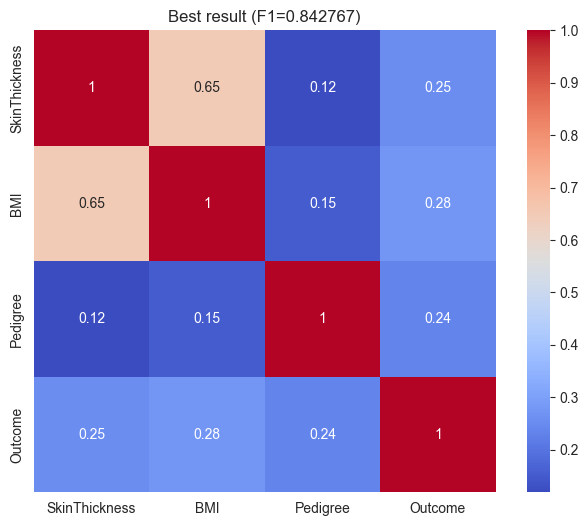

In [33]:
best_result = results[0]
worst_result = results[-1]

print('Best: ' + f'f1 = {best_result.metrics["f1_score"]}, k = {best_result.k}, columns = {best_result.columns}')
print('Worst: ' + f'f1 = {worst_result.metrics["f1_score"]}, k = {worst_result.k}, columns = {worst_result.columns}')

# Correlation matrix for the best and worst feature set
def plot_correlation_matrix(x_data: pd.DataFrame, y_data: pd.Series, columns: list[str], title: str):
    # Combine the feature columns with the target 'y_train' column
    combined_data = x_data[columns].copy()
    combined_data['Outcome'] = y_data  # Assuming 'Outcome' is the name of the target column
    
    # Compute correlation matrix
    corr_matrix = combined_data.corr()
    print(corr_matrix)
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, square=True)
    plt.title(title)
    plt.show()

# Correlation matrix for the best result (features + target)
plot_correlation_matrix(x, y_train, best_result.columns, f'Best result (F1={best_result.metrics["f1_score"]:.6f})')

               BloodPressure  Pedigree       Age   Outcome
BloodPressure       1.000000  0.008047  0.346939  0.164165
Pedigree            0.008047  1.000000  0.071654  0.235029
Age                 0.346939  0.071654  1.000000  0.327728
Outcome             0.164165  0.235029  0.327728  1.000000


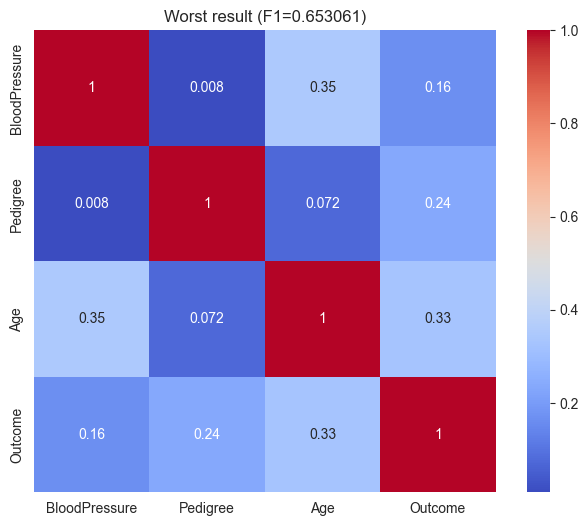

In [34]:
# Correlation matrix for the worst result (features + target)
plot_correlation_matrix(x, y_train, worst_result.columns, f'Worst result (F1={worst_result.metrics["f1_score"]:.6f})')

Наборы признаков, которые показывают лучшие и худшие результаты для модели k-NN, имеют существенные различия в корреляциях между признаками и целевой переменной (Outcome).

Возможные причины, почему это происходит: модель предсказывает тем более точные результаты, чем:
- больше корреляция признаков с целевой переменной
- меньше корреляция признако между собой (чтобы избежать мультиколлинеарности)
- больше число ближайших соседей ($k$) (чтобы снизить влияние выбросов и шума)

Но оптимизировать эти параметры по отдельности -- опрометчиво, необходимо находить сбалансированное решение, например, с помощью кросс-валидации